### Libraries

In [21]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import time
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from tqdm import tqdm

#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_2022_2023_2024.csv",
        "trainingSize": .60,
        "validationSize": .2,
        "testSize": .2
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    }
}

In [2]:
def plotDatasetSplit(X_train, X_train_dates, X_test, X_test_dates):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=X_train["Demand"], mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=X_test["Demand"], mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (kWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.show()

In [3]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [4]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)
    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test, y_pred)

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)
        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test, y_pred_permuted)

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

In [43]:
def addNLags(df, lags=1):
    lag_df = df.copy()
    for i in range(1, lags + 1):
        lag_df[f'lag_{i}'] = lag_df['Demand'].shift(96 + i)
    return lag_df.dropna()



def addNLags2(df, lags=1):
    lag_df= df.copy()
    for i in range(2, lags + 1):
        lag_df[f'lag_{i}'] = lag_df["Demand"].shift(i * 96)

In [44]:
def normalizeData(data):
    df = data.copy()
    df = df.drop("Demand", axis=1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

## Machine Learning Models

### Split Dataset

In [47]:
df2 = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df2["Date"] = pd.to_datetime(df2["Date"])
df2 = df2.loc[df2["Date"] <= pd.to_datetime('2023-30-12 0:00', format='%Y-%d-%m %H:%M')]
dates = df2["Date"]
dates = pd.to_datetime(dates)
df2 = df2.drop(columns=["Date", "Minute",  "Consumo_red [kW]"], axis=1)
df2 = df2.rename(columns={'Consumo_total [kW]': 'Demand'})

trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* df2.shape[0])

X_train = df2.loc[:trainingSize, :].copy()
X_train_dates = dates.loc[:trainingSize].copy()
X_test = df2.loc[trainingSize:, :].copy()
X_test_dates = dates.loc[trainingSize:].copy()

print(f"Training and Validation Size: {trainingSize}")
print(f"Test Size: {len(df2)-trainingSize}")

Training and Validation Size: 55911
Test Size: 13978


In [8]:
plotDatasetSplit(X_train, X_train_dates, X_test, X_test_dates)

### Models to Test

In [9]:
models, models_names = [], []

#Tree Models

for n in [20, 50]:
    LGBM = LGBMRegressor(n_estimators=n, random_state=123, verbose=-1)
    XGB = XGBRegressor(n_estimators=n, random_state=123)
    GBM = GradientBoostingRegressor(n_estimators=n, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    models.append(GBM)
    models_names.append("GBM_" + str(n))


#KNNr
for n in [10, 20]:
    KNNR = KNeighborsRegressor(n_neighbors=n, weights = 'uniform')
    models.append(KNNR)
    models_names.append("KNNr_" + str(n) + "_" + 'uniform')
        
#Other Models


### Walking Forward Validation

<img src="https://miro.medium.com/v2/resize:fit:1400/1*lmUY2pKwxu5kwA1II6yAbQ.png"></img>

In [10]:
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val","Mean_MRSE_Test", "Mean_MAE_Test", "Mean_RMSE_Val", "Mean_MAE_Val"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_test2 = X_test.copy()
        X2 = X.copy()
        if 'KNN' in model_name or 'SVR' in model_name:
            X_test2 = normalizeData(X_test2)
            X2 = normalizeData(X2)
        else:
            X2 = X2.drop(columns=["Demand"], axis=1).to_numpy()
            X_test2 = X_test2.drop(columns=["Demand"], axis=1).to_numpy()
            
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_test, rmse_val, mae_test, mae_val = [], [], [], []
        for i, (train_index, eval_index) in enumerate(tscv.split(X)):
            X_train, X_val = X2[train_index], X2[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            model.fit(X_train, y_train)

            #Validation Scores
            y_pred_val = model.predict(X_val)
            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            
            #Test Scores
            y_pred_test = model.predict(X_test2)
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, np.mean(rmse_test), np.mean(mae_test), np.mean(rmse_val), np.mean(mae_val)] 
    
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "RMSE_Test", "MAE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        for i in range(4):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 2
            col = i % 2
            ax = axes[row, col]
            for index, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()
    return results

 12%|█▎        | 1/8 [00:01<00:12,  1.81s/it]

Model: LGBM_20 ===> Mean Test MAE: 3.7179174176777634, RMSE: 5.080882349796129


 25%|██▌       | 2/8 [00:03<00:11,  1.88s/it]

Model: XGB_20 ===> Mean Test MAE: 3.756298763633418, RMSE: 5.415283589967732


 38%|███▊      | 3/8 [00:26<00:57, 11.48s/it]

Model: GBM_20 ===> Mean Test MAE: 3.8234139918461176, RMSE: 5.195397242414382


 50%|█████     | 4/8 [00:30<00:34,  8.65s/it]

Model: LGBM_50 ===> Mean Test MAE: 3.5661994820954215, RMSE: 5.242722416401301


 62%|██████▎   | 5/8 [00:35<00:21,  7.33s/it]

Model: XGB_50 ===> Mean Test MAE: 3.9829323156212775, RMSE: 5.628725536865361


 75%|███████▌  | 6/8 [01:50<01:00, 30.21s/it]

Model: GBM_50 ===> Mean Test MAE: 3.5876738862691924, RMSE: 5.227568055583229


 88%|████████▊ | 7/8 [02:04<00:24, 24.81s/it]

Model: KNNr_10_uniform ===> Mean Test MAE: 4.252193354993627, RMSE: 6.920241312607534


100%|██████████| 8/8 [02:18<00:00, 17.29s/it]

Model: KNNr_20_uniform ===> Mean Test MAE: 4.266245918706613, RMSE: 6.771505274114814


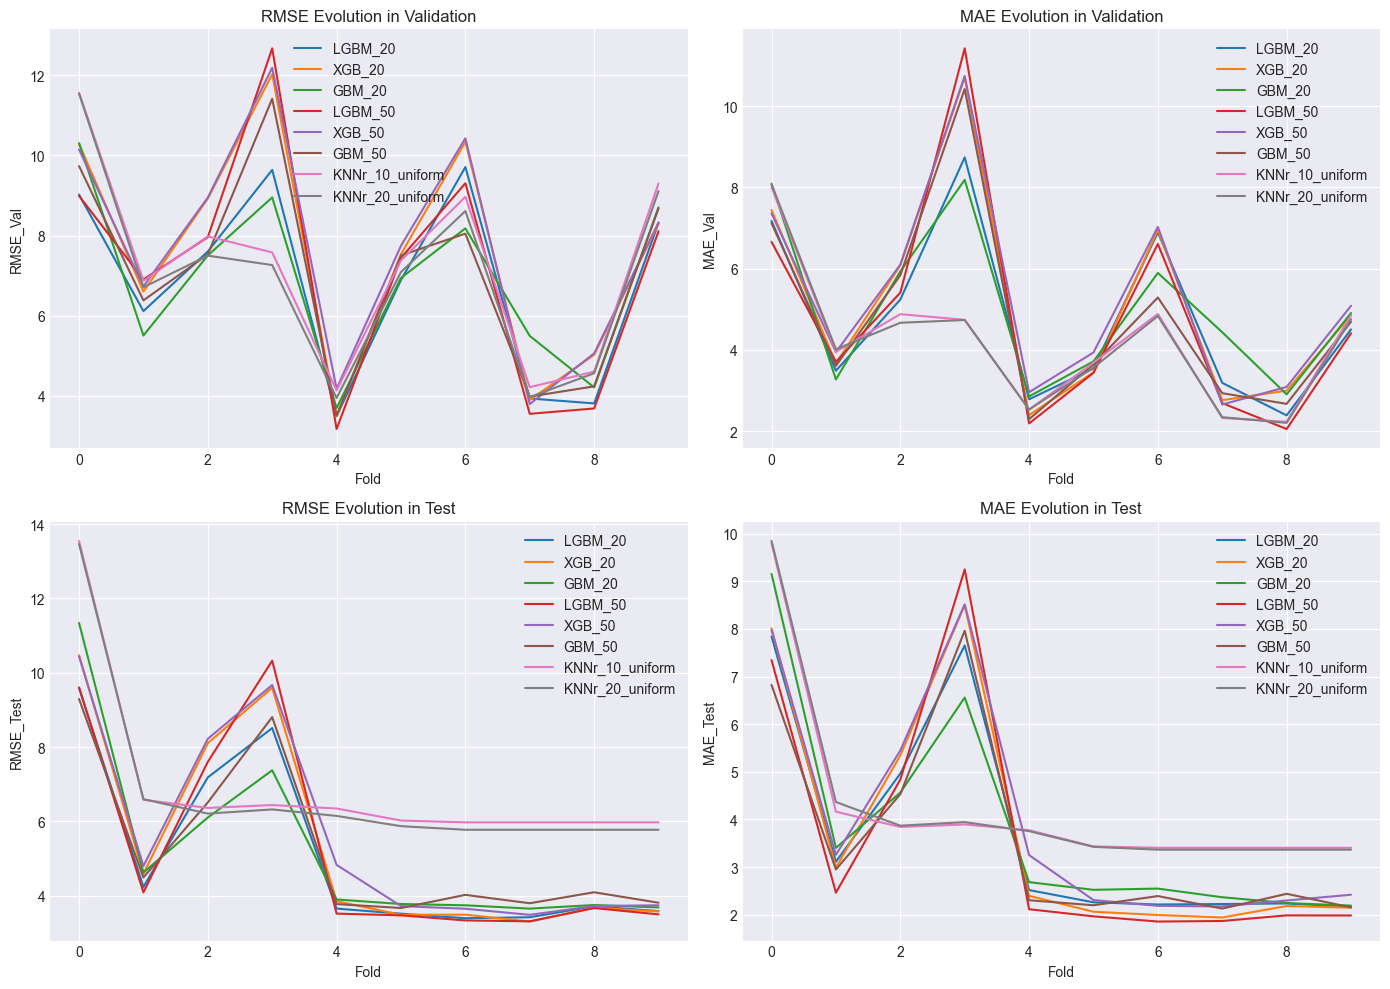

In [11]:
results = walkForwardValidation(X_train, X_train["Demand"], X_test, X_test["Demand"], models, models_names, parameters, plot=True, fixed_train=False)
results.to_csv("../data/Processed_Data/Walking_Forward_Validation_NoFix.csv", index=None)

<img src="https://miro.medium.com/v2/resize:fit:1400/1*M3WnQy2H4GFtTctSgvQ48g.png">

 12%|█▎        | 1/8 [00:01<00:07,  1.04s/it]

Model: LGBM_20 ===> Mean Test MAE: 3.664739518862619, RMSE: 5.31966771733823


 25%|██▌       | 2/8 [00:03<00:11,  1.87s/it]

Model: XGB_20 ===> Mean Test MAE: 3.8480693325677455, RMSE: 5.546698330632573


 38%|███▊      | 3/8 [00:08<00:17,  3.43s/it]

Model: GBM_20 ===> Mean Test MAE: 3.8679863776653756, RMSE: 5.347754297470492


 50%|█████     | 4/8 [00:10<00:11,  2.83s/it]

Model: LGBM_50 ===> Mean Test MAE: 3.752317524247991, RMSE: 5.533773303421643


 62%|██████▎   | 5/8 [00:13<00:08,  2.78s/it]

Model: XGB_50 ===> Mean Test MAE: 3.91592567442731, RMSE: 5.606390390710539


 75%|███████▌  | 6/8 [00:26<00:12,  6.28s/it]

Model: GBM_50 ===> Mean Test MAE: 3.6149525858479366, RMSE: 5.238520940380173


 88%|████████▊ | 7/8 [00:29<00:05,  5.18s/it]

Model: KNNr_10_uniform ===> Mean Test MAE: 3.7520512681574716, RMSE: 6.07038658707583


100%|██████████| 8/8 [00:32<00:00,  4.09s/it]

Model: KNNr_20_uniform ===> Mean Test MAE: 3.6988884835803852, RMSE: 5.855278640757992


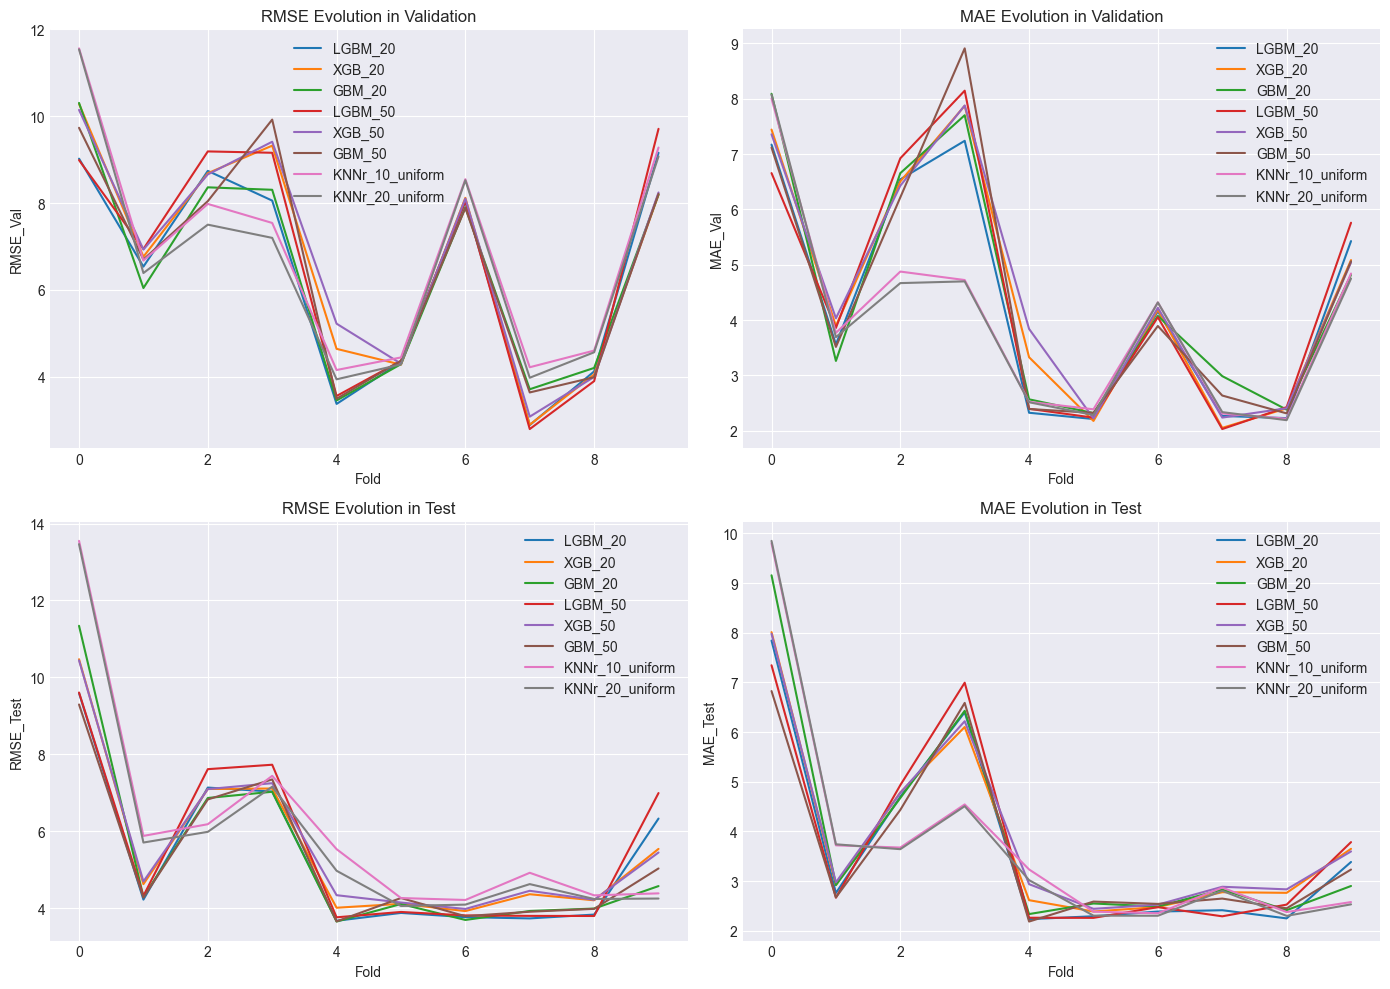

In [12]:
	
results = walkForwardValidation(X_train, X_train["Demand"], X_test, X_test["Demand"], models, models_names, parameters, plot=True, fixed_train=True)
results.to_csv("../data/Processed_Data/Walking_Forward_Validation_Fix.csv", index=None)

### Find Best K

In [15]:
def findBestK(X, y, X_test, y_test, max_k, params):
    final_mae_list, final_rmse_list = [], []
    best_mae, best_rmse, best_k = float('inf'), float('inf'), 0
    trainingSize = X.shape[0]-int(parameters["dataset"]["validationSize"] * X.shape[0])
    for k in tqdm(range(1, max_k), total=max_k, desc="Finding Best K..."):
        knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')
        X_train, X_val = X[:trainingSize, :], X[trainingSize:, :]    
        y_train, y_val = y[:trainingSize], y[trainingSize:]  
        mae_list , rmse_list = [], []

        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(root_mean_squared_error(y_test, y_pred))

        mae, rmse = np.mean(mae_list), np.mean(rmse_list)
        final_mae_list.append(mae)
        final_rmse_list.append(rmse)
        if mae <= best_mae and rmse <= best_rmse:
            best_mae = mae
            best_rmse = rmse
            best_k = k

    #MAE and RMSE plots per k
    fig = make_subplots(rows=2, cols=1, subplot_titles=("MAE Value per K", "RMSE Value per K"))
    fig.append_trace(go.Scatter(x=list(range(1, max_k)), y=final_mae_list, mode='lines'), row=1, col=1)
    fig.append_trace(go.Scatter(x=list(range(1, max_k)), y=final_rmse_list, mode='lines'), row=2, col=1)
    fig.update_xaxes(title_text="K Value", row=1, col=1)
    fig.update_yaxes(title_text="Mean Absolute Error", row=1, col=1)
    fig.update_xaxes(title_text="K Value", row=2, col=1)
    fig.update_yaxes(title_text="Root Mean Squared Error", row=2, col=1)
    fig.update_layout(
        width = 850,
        height = 700,
        margin=dict(l=20, r=20, t=35, b=25),
        showlegend=False
    )
    fig.show()
    print(f"Best K: {best_k}, MAE: {best_mae}, RMSE: {best_rmse}")

findBestK(normalizeData(X_train), X_train["Demand"], normalizeData(X_test), X_test["Demand"], max_k=50, params=parameters)

Finding Best K...:   0%|          | 0/50 [00:00<?, ?it/s]

Finding Best K...:  98%|█████████▊| 49/50 [01:33<00:01,  1.90s/it]


Best K: 28, MAE: 3.352781853334214, RMSE: 5.6892401545509905


### Tune Exogenous Variables

Text(0.5, 1.0, 'Pearson Correlation Matrix')

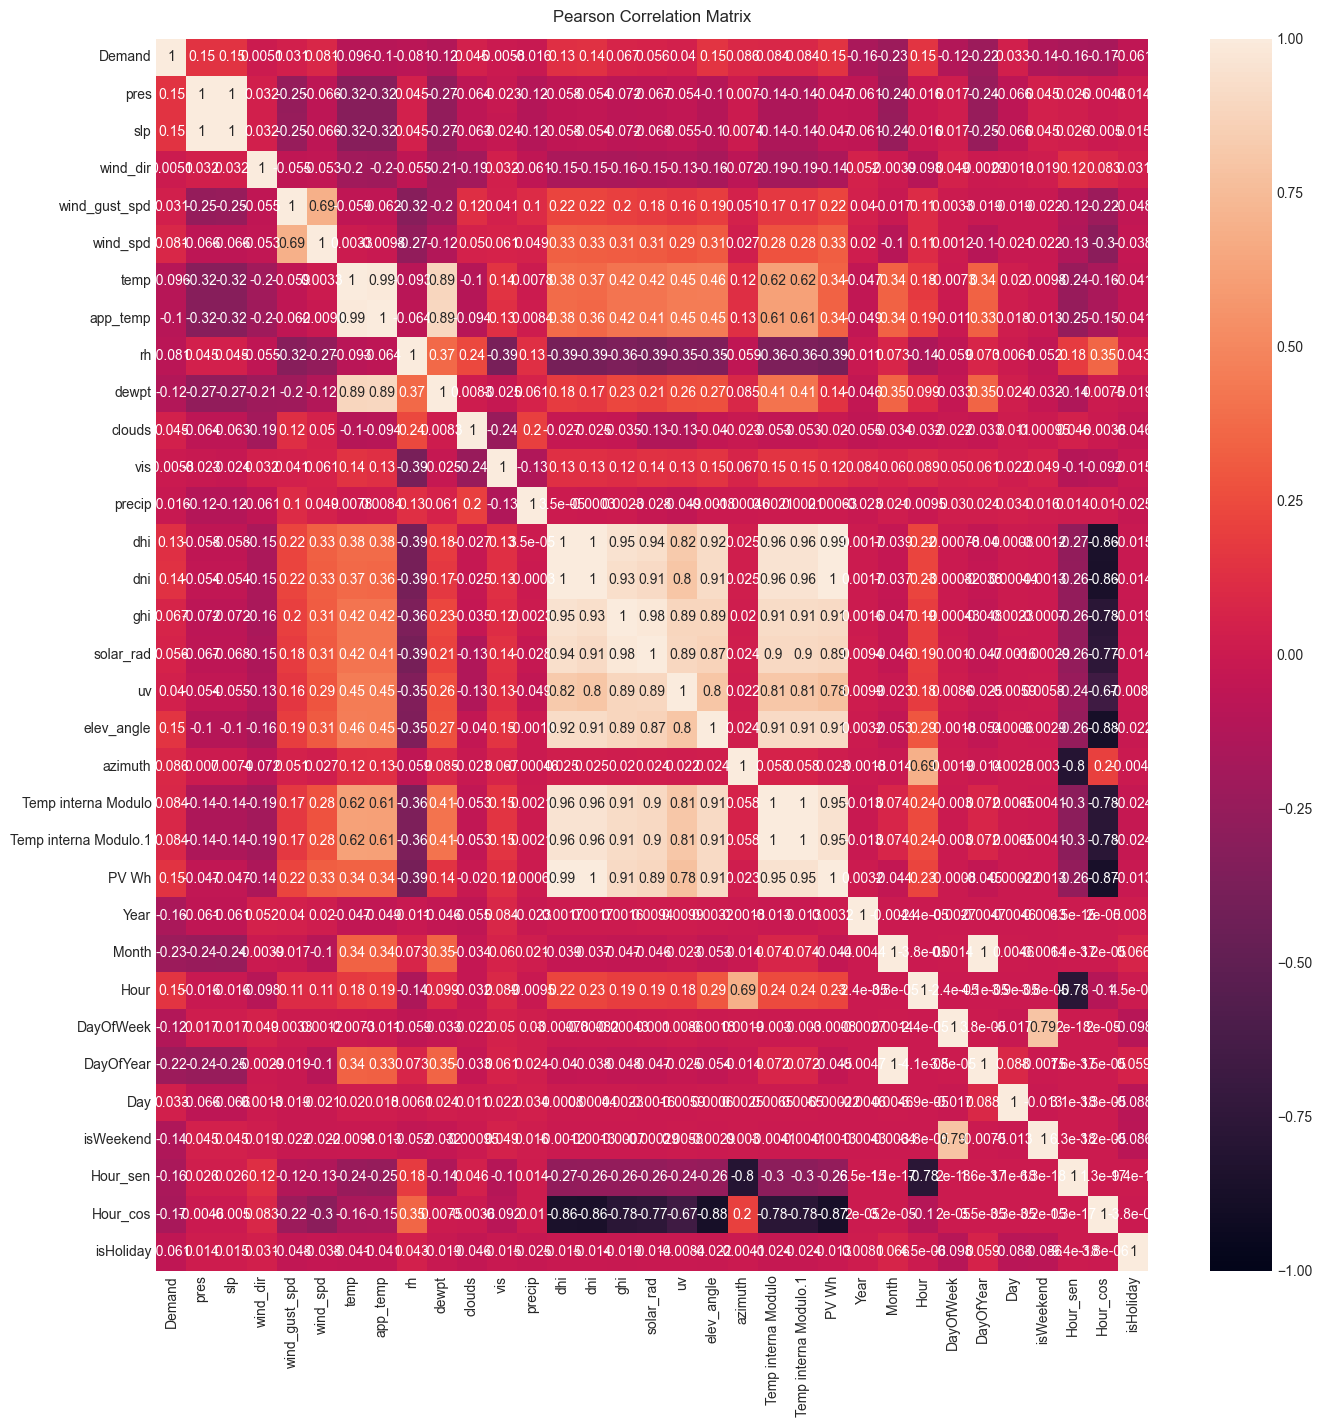

In [16]:
#Correlation Map using Pearson Correlation
plt.figure(figsize=(16,16))
#corr_df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
#Drop Columns
#corr_df = corr_df.drop(columns=["Date"])
heatmap = sns.heatmap(df2.corr('pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Pearson Correlation Matrix', fontdict={'fontsize': 12}, pad=12)

In [46]:
knn_model = KNeighborsRegressor(n_neighbors=10, weights='distance')

X_train = addNLags(X_train, 1)
X_test = addNLags(X_test, 1)
#model = GradientBoostingRegressor(n_estimators=100, random_state=123)
knn_model.fit(normalizeData(X_train), X_train["Demand"])
#model.fit(X_train2.to_numpy(), X_train["Demand"])
columns = list(X_test.columns)
columns.remove('Demand')
columns = np.array(columns)
preds = knn_model.predict(normalizeData(X_test))
print(f"MAE: {mean_absolute_error(X_test["Demand"].to_numpy(), preds)}, RMSE: {root_mean_squared_error(X_test["Demand"].to_numpy(), preds)}")
permutation_feature_importance(knn_model, normalizeData(X_test), X_test["Demand"], columns)

MAE: 2.9586828684368656, RMSE: 5.459912444769377


  2%|▏         | 1/43 [00:03<02:28,  3.53s/it]


KeyboardInterrupt: 

In [56]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "learning_rate": 0.05,
    "n_estimators": 500,
    "n_jobs": -1,
    "metric": "mae",
    "verbose": 1
}
model = LGBMRegressor(**params)
X_train2 = X_train.drop(columns=["Demand"], axis=1).to_numpy()
X_test2 = X_test.drop(columns=["Demand"], axis=1).to_numpy()
model.fit(X_train2, X_train["Demand"])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6435
[LightGBM] [Info] Number of data points in the train set: 55912, number of used features: 42
[LightGBM] [Info] Start training from score 7.991961


LGBMRegressor(learning_rate=0.05, metric='mae', n_estimators=500, n_jobs=-1,
              objective='regression', verbose=1)

In [57]:
y_pred = knn_model.predict(X_test2)
plotPredictions(X_test_dates, y_pred, X_test["Demand"])

ValueError: X has 42 features, but KNeighborsRegressor is expecting 43 features as input.